<a href="https://colab.research.google.com/github/DEli-26/DS_Practicum/blob/main/07_churn/deli_proj_pract_07_churn_v2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font size=6><b>**Я.Практикум. Проект №7**</b></font>
    
<font size=6><b>**Обучение с учителем**</b></font>

***

# Постановка задачи

**Заказчик:** «Бета-Банк».

**Цель:** Спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. 

**Задачи:** 
1. изучить данные;
1. разделить данные на обучающую, валидационную и тестовую выборки;
1. обучить модель машинного обучения;
1. получить среднее гармоническое значение точности и полноты модели на тестовой выборке - F1, не менее 59%;
1. измерить ROC-AUC модели и сравнить ее значение с F1-мерой.

**Исходные данные:** исторические данные о поведении клиентов и расторжении договоров с банком. 

# Обзор данных

## Подготовка окружения
Загрузим библиотеки, необходимые для выполнения проекта, и сами данные.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from tqdm.notebook import tqdm

try:
    import phik
except: 
    ! pip install phik
    import phik

# Темная тема графиков
plt.style.use('dark_background')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 690 kB 5.1 MB/s 


--Здесь была загрузка данных с Google Drive--

Вызовем первые 5 строк, общую информацию о таблице, а также количество дубликатов.

In [4]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [6]:
df.duplicated().sum()

0

In [7]:
df['RowNumber'].nunique()

10000

К признакам относятся следующие столбцы:
* `RowNumber` — индекс строки в данных;
* `CustomerId` — уникальный идентификатор клиента;
* `Surname` — фамилия;
* `CreditScore` — кредитный рейтинг;
* `Geography` — страна проживания;
* `Gender` — пол;
* `Age` — возраст;
* `Tenure` — сколько лет человек является клиентом банка;
* `Balance` — баланс на счёте;
* `NumOfProducts` — количество продуктов банка, используемых клиентом;
* `HasCrCard` — наличие кредитной карты;
* `IsActiveMember` — активность клиента;
* `EstimatedSalary` — предполагаемая зарплата.

Целевой признак таблицы:
* `Exited` — факт ухода клиента.

**По полученным данным видно следующее:**

* исходная таблица содержит 14 столбцов и 10 000 объектов для исследования;
* столбец `RowNumber` дублирует значения индекса, значит его можно исключить из рассмотрения;
* в столбце `Tenure` присутствуют пропуски, которые надо обработать перед формированием модели.

## Анализ взаимосвязей в данных

Определим наличие взаимосвязей между данными в разных столбцах. Для этого используем библиотеку phik, которая определяет нелинейные взаимосвязи, в том числе, категориальных и ординарных переменных.

interval columns not set, guessing: ['RowNumber', 'CustomerId', 'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']


/usr/local/lib/python3.7/dist-packages/phik/data_quality.py:62: UserWarning: The number of unique values of variable Surname is large: 2932. Are you sure this is not an interval variable? Analysis for pairs of variables including Surname can be slow.
  col, df[col].nunique()


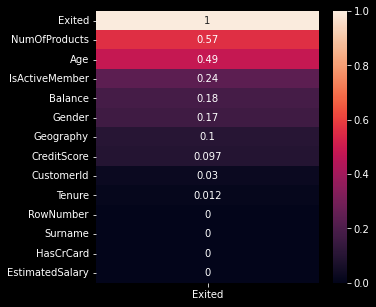

In [8]:
plt.figure(figsize=(5, 5))
sns.heatmap(df.phik_matrix(dropna=False)[['Exited']].sort_values(by='Exited', 
                                                                 ascending=False), 
            annot=True)
plt.show()

На полученном рисунке видно, что отсутствует корреляция целевого признака `Exited` со следующими признаками: `EstimatedSalary`, `HasCrCard`, `Surname`, `RowNumber`.
Кроме того, для признаков `CustomerId` и `Tenure` корреляция менее 5%.
Таким образом, перечисленные признаки не должны оказывать существенного вклада в точность модели и могут увеличивать время ее обучения.
В этой связи представляется целесообразным их удаление из рассматриваемой таблицы. 

In [9]:
df_cut = df.drop(columns=[
    'RowNumber', 'Surname', 'HasCrCard', 'EstimatedSalary', 'CustomerId',
    'Tenure'
],
                 axis=1)

## Кодирование данных

В настоящей работе планируется анализировать модели дерева решений, случайного леса и логистической регрессии.
Для перечисленных типов моделей масштабирование и стандартизация данных практически не оказывает влияния на их точность.

Значения в категориальных столбцах заменим по принципу прямого кодирования.

In [10]:
df_cut = pd.get_dummies(df_cut, drop_first=True)
df_cut.head()

,CreditScore,Age,Balance,NumOfProducts,IsActiveMember,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,0.00,1,1,1,0,0,0
1,608,41,83807.86,1,1,0,0,1,0
2,502,42,159660.80,3,0,1,0,0,0
3,699,39,0.00,2,0,0,0,0,0
4,850,43,125510.82,1,1,0,0,1,0


## Анализ баланса целевого признака

Исследуем баланс классов целевого признака.

In [11]:
df_cut['Exited'].value_counts(normalize=True)

0    0.7963
1    0.2037
Name: Exited, dtype: float64

Полученные значения показывают, что значение `1` встречается в 4 раза реже чем `0`, что может оказать существенное влияние на точность результатов.
В этой связи необходимо рассмотреть возможность компенсации дисбаланса.

## Заключение по обзору данных

Исследуемая таблица содержит данные о 10 000 клиентах банка.  
Однако не для всех признаков установлена взаимосвязь с целевым признаком.
В этой связи в таблице сокращено количество признаков с 13 до 7, при этом категориальные признаки закодированы по принципу прямого кодирования.
Определен дисбаланс классов для целевого признака, что должно быть исследовано при разработке модели машинного обучения. 

# Подготовка данных

## Подготовка выборок

Выделим названия признаков и целевого признака в переменные `X` и `y` соответственно.

In [12]:
X = df_cut.drop('Exited', axis=1).columns
y = ['Exited']

Разделим исходную таблицу на обучающую, валидационную и тестовую выборки в пропорции 3:1:1 соответственно.

In [13]:
df_train, df_valid_test = train_test_split(df_cut,
                                           test_size=.4,
                                           random_state=26,
                                           stratify=df[y])
df_valid, df_test = train_test_split(df_valid_test,
                                     test_size=.5,
                                     random_state=26,
                                     stratify=df_valid_test[y])

Проверим правильность разделения, определив длину каждой выборки.

In [14]:
len(df_train)

6000

In [15]:
len(df_valid)

2000

In [16]:
len(df_test)

2000

## Пороговое значение метрик 

Определим пороговые значение метрик исходя из условия предсказания всем пользователям в тестовой выборке положительного исхода - значения `1`. Предсказание значения `0` не показательно, так как в этом случае F1-метрика так же принимает нулевое значение.

In [17]:
round(f1_score(df_test[y], [1] * len(df_test)), 3)

0.339

In [18]:
round(roc_auc_score(df_test[y], [0] * len(df_test)), 3)

0.5

Полученные значения будем использовать для оценки качества разработанных моделей.

## Подготовка моделей

Решаемая задача сводится к определению классификационной модели. Рассмотрим следующие типы моделей:
* дерево решений;
* случайный лес;
* логистическая регрессия.

Выбор гиперпараметров перечисленных моделей выполним при помощи класса RandomizedSearchCV. 
Для этого определим пространство их возможных значений и создадим функции обучения каждой модели.

In [45]:
#Пространство параметров дерева решений
max_depth = [int(x) for x in np.linspace(2, 50, num=49)]
max_features = [
    int(x) for x in np.linspace(start=2, stop=len(X), num=(len(X) - 1))
]
max_features.append('log2')
max_features.append('sqrt')
min_samples_split = [int(x) for x in np.linspace(2, 20, num=19)]
min_samples_leaf = [int(x) for x in np.linspace(2, 20, num=19)]
max_leaf_nodes = [int(x) for x in np.linspace(2, 50, num=49)]
class_weight = ['balanced', None]
criterion = ['gini', 'entropy']
space_tree = {
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'max_leaf_nodes': max_leaf_nodes,
    'class_weight': class_weight,
    'criterion': criterion
}

#Пространство параметров случайного леса
n_estimators = [int(x) for x in np.linspace(start=10, stop=100, num=19)]
space_rf = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'max_leaf_nodes': max_leaf_nodes,
    'class_weight': class_weight,
    'criterion': criterion
}

#Пространство параметров логистической регрессии
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
max_iter = [int(x) for x in np.linspace(start=10, stop=250, num=15)]
space_logreg = {
    'solver': solver,
    'max_iter': max_iter,
    'class_weight': class_weight
}

# Параметр кросвалидации
skf = StratifiedKFold(10, shuffle=True, random_state=26)

In [46]:
def decision_tree(data):
    model = RandomizedSearchCV(
        estimator=DecisionTreeClassifier(random_state=26),
        param_distributions=space_tree,
        cv=skf,
        n_iter=100,
        scoring='roc_auc',
        random_state=26)
    model.fit(data[X], data[y])
    return model

In [47]:
def random_forest(data):
    model = RandomizedSearchCV(estimator=RandomForestClassifier(
        random_state=26, n_jobs=-1),
                               param_distributions=space_rf,
                               n_jobs=-1,
                               cv=skf,
                               n_iter=100,
                               scoring='roc_auc',
                               random_state=26)
    model.fit(data[X], data[y])
    return model

In [48]:
def model_logreg(data):
    model = RandomizedSearchCV(estimator=LogisticRegression(random_state=26,
                                                            n_jobs=-1),
                               param_distributions=space_logreg,
                               n_jobs=-1,
                               cv=skf,
                               n_iter=100,
                               scoring='roc_auc',
                               random_state=26)
    model.fit(data[X], data[y])
    return model

## Заключение по подготовке данных

Проведено разделение исходной таблицы на обучающую, валидационную и тестовую выборки в пропорции 3:1:1 соответственно.
В случае предсказания всем клиентам в тестовой выборке целевого класса "1" - ухода из компании, метрики F1 и AUC ROC составляют 33,9% и 50% соответственно. 

# Моделирование

## Обучение моделей на полных данных

Учитывая, что искомая метрика F1 зависит от значения порога классификации, для выбора лучшей модели будем использовать метрику ROC-AUC и валидационную подвыборку.
Затем для лучшей модели подберем значение порога на той же подвыборке и проверим его на тестовой подвыборке. 

Вызовем созданные функции, а значения метрики сведем в таблицу. 

In [49]:
model_dt = decision_tree(df_train)

In [50]:
model_rf = random_forest(df_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


In [51]:
model_lg = model_logreg(df_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [52]:
def rocauc_tables(models):
    names = ['model_dt', 'model_rf', 'model_lg']
    metrics = {}
    for i in range(len(models)):
        metrics[names[i]] = round(roc_auc_score(df_valid[y], models[i].predict(df_valid[X])), 3)
    return pd.DataFrame(metrics.values(), metrics.keys())

In [53]:
rocauc_table = rocauc_tables([model_dt, model_rf, model_lg])
rocauc_table.columns = ['norm']
cm = sns.dark_palette("g", as_cmap=True)
rocauc_table.style.background_gradient(cmap=cm)

,norm
model_dt,0.738000
model_rf,0.789000
model_lg,0.725000


Различие значений полученных метрик менее 1,5%.
Учитывая существующий дебаланс классов целевого признака, представляется целесообразным провести анализ возможности его компенсации.
С этой целью применим методики downsampling и upsampling.

## Downsampling

Разделим обучающую выборку на две, в соответствии со значением целевого признака. 
А затем объединим в одну, уменьшив количество нулевых значений в 4 раза.
Проверим баланс классов, посчитав среднее в столбце с целевым признаком.

In [54]:
zeros = df_train[df_train[y[0]] == 0]
ones = df_train[df_train[y[0]] == 1]

df_train_down = shuffle(pd.concat([zeros.sample(frac=.25, random_state=26)] +
                                  [ones]),
                        random_state=26)
df_train_down[y].mean()

Exited    0.505795
dtype: float64

Доля `1` в столбце составляет 50%.

In [55]:
len(df_train) / len(df_train_down)

2.4834437086092715

Размер обучающей выборки уменьшился примерно в 2,5 раза.

Обучим модели при помощи определенных ранее функций и сведем их метрики в таблицу.

In [56]:
model_dt_down = decision_tree(df_train_down)

In [57]:
model_rf_down = random_forest(df_train_down)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


In [58]:
model_lg_down = model_logreg(df_train_down)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Анализ качества предсказания моеделей с downsampling проведем позднее.

## Upsampling

Разделим обучающую выборку на две, в соответствии со значением целевого признака. 
А затем объединим в одну, увеличив количество положительных значений в 4 раза.
Проверим баланс классов, посчитав среднее в столбце с целевым признаком.

In [59]:
df_train_up = shuffle(pd.concat([zeros] + [ones] * 4), random_state=26)
df_train_up[y].mean()

Exited    0.50569
dtype: float64

In [60]:
model_dt_up = decision_tree(df_train_up)

In [61]:
model_rf_up = random_forest(df_train_up)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


In [62]:
model_lg_up = model_logreg(df_train_up)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [63]:
rocauc_table['down'] = rocauc_tables([model_dt_down, model_rf_down, model_lg_down])
rocauc_table['up'] = rocauc_tables([model_dt_up, model_rf_up, model_lg_up])

rocauc_table.style.background_gradient(cmap=cm)

,norm,down,up
model_dt,0.738000,0.759000,0.767000
model_rf,0.789000,0.785000,0.792000
model_lg,0.725000,0.727000,0.725000


Согласно представленным в таблице данным видно, что нивелирование дисбаланса классов целевого признака за счет увеличения или уменьшения тренеровочной выборки ведет к увеличению значения метрики ROC-AUC. 
Однако изменени характеристики не превышает 0,5%, что, по всей видимости, носит случайный характер.

В целом, down/up-sampling приводит только к изменению баланса классов, что в конечном итоге скажется исключительно на значении порога для используемой итоговой метрики (в настоящем проекте - F1).
Таким образом, учитывая, что сокращение обучающей выборки в 2,5 раза, повлечет за собой недообучение модели, а дублирование данных - переобучение, наиболее целесообразным решением является использовать полную выборку для дальнейшего моделирования.

## Выбор порога для метрики F1

Определим значение целевой метрики со стандартным порогом, равным 0,5. 

In [64]:
f1_score(df_valid[y], model_rf.predict(df_valid[X]))

0.6256517205422315

Полученное значение выше аналогичного для модели baseline почти в два раза. 
Учитывая, что на тестовой выборке указанная метрика, скорее всего, изменится в худшую сторону, целесообразно провести анализ  возможности ее улучшения за счет изменения порога классификации.
Для этого создадим столбец со значениями вероятности определения к тому или иному классу.

In [65]:
df_valid["model_rf_proba"] = np.NaN
df_valid["model_rf_proba"] = 1 - model_rf.predict_proba(df_valid[X])

Определим перечень всех существующих значений вероятностей и добавим его к нулевому значению.

In [66]:
thrs = [0] + list(df_valid["model_rf_proba"].unique())

Переберем в цикле значения метрики F1 при изменении порога по всем значениям вероятности.

In [67]:
result = []

for thr in tqdm(thrs):
    df_valid["model_rf_best"] = (df_valid["model_rf_proba"] > thr) * 1
    result.append((thr, f1_score(df_valid[y], df_valid["model_rf_best"])))

  0%|          | 0/1781 [00:00<?, ?it/s]

Выведем значение порога, обеспечивающего получение максимальное значение целевой метрики. 

In [68]:
t = pd.DataFrame(result, columns=["thr", "f1"])

thr_best = t.loc[t["f1"] == t["f1"].max(), "thr"].values[0]

t[t["f1"] == t["f1"].max()]

,thr,f1
1362,0.608304,0.637975


Полученное значение лучше "ненастроенного" на 1,2%.

В дальнейшем будем использовать его для расчета целевой метрики на тестовой подвыборке.

## Проверка на тестовой подвыборке

Проведем проверку выбранной модели и порога классификации на тестовой выборке.

In [70]:
df_test["model_rf_proba"] = np.NaN
df_test["model_rf_proba"] = 1 - model_rf.predict_proba(df_test[X])
df_test["model_rf_best"] = (df_test["model_rf_proba"] > thr_best) * 1
f1_score(df_test[y], df_test["model_rf_best"])

0.6277915632754343

Полученное значение удовлетворяет заданному критерию в 0,59 и отличается от аналогичного на валидационной выборке менее, чем на 1%.
Это свидетельствует об удачном выборе параметров моделирования и пороге классификации.

## Заключение по моделированию

Моделирование без учета дисбаланса целевого класса показало, что метрика ROC-AUC для модели случайного леса превосоходит аналогичные для моделей дерева решений и логистической регрессии. 
Исследование возможности компенсации дисбаланса классов за счет down/up-sampling подтвердило отуствие эффективности рассмотренных методов.
В этой связи, модель случайного леса использована, обученная на полной выборке, использована для подбора порога классификации, обеспечивающего лучшее значение метрики F1 на валидационной выборке.
Значение порога составило 0,608, что позволило получить значение метрики F1 на тестовой подвыборке 0,627, что удовлетворяет заданному критерию в 0,59.


# Выводы

Проведено исследование по разработке модели машинного обучения для прогнозирования, уйдёт клиент из «Бета-Банка» в ближайшее время или нет.

Изучены исторические данные о поведении 10 000 клиентов и расторжении договоров с банком.  
Получено, что не все признаки влияют на значение целевого признака.
В этой связи в таблице сокращено количество признаков с 13 до 7, а категориальные признаки закодированы по принципу прямого кодирования.
Дисбаланс классов для целевого признака составил 1:4. 

Данные разделены на обучающую, валидационную и тестовую выборки.
В случае предсказания всем клиентам в тестовой выборке целевого класса "1" - ухода из компании, метрики F1 и AUC ROC составляют 33,9% и 50% соответственно. 

При помощи класса случайного поиска гиперпараметров определены 3 типа моделей: дерево решений, случайный лес и логистическая регрессия. 
Моделирование без учета дисбаланса целевого класса показало, что метрика ROC-AUC для модели случайного леса превосоходит аналогичные для моделей дерева решений и логистической регрессии. 
Исследование возможности компенсации дисбаланса классов за счет down/up-sampling подтвердило отуствие эффективности рассмотренных методов.
В этой связи, модель случайного леса использована, обученная на полной выборке, использована для подбора порога классификации, обеспечивающего лучшее значение метрики F1 на валидационной выборке.
Значение порога составило 0,608, что позволило получить значение метрики F1 на тестовой подвыборке 0,627, что удовлетворяет заданному критерию в 0,59.